In [10]:
#Just run this box once with 'Shift'+'Enter'. It loads all the things you need to work with the data. 
from __future__ import print_function

import sys
import os
import scipy
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import datacube

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
from digitalearthau.utils import wofs_fuser
sys.path.append('../10_Scripts/')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'digitalearthau'

# Enter your variables in the box below and choose values

Barmah choke: 
lat = -35.92
lon = 145.00
buffer = 10000

Boundary Bend:
lat = -34.71966901
lon = 143.1698626
buffer = 10000

Niemur:
lat = -35.277
lon = 144.3477
buffer = 5500

Macquarie Marshes:
lat = -30.8072
lon = 147.5149
buffer = 10000

Gunbower:
lat = -35.942574
lon = 144.46466
buffer = 10000

Wee Wai:
lat = -30.2033
lon = 149.4361
buffer = 10000

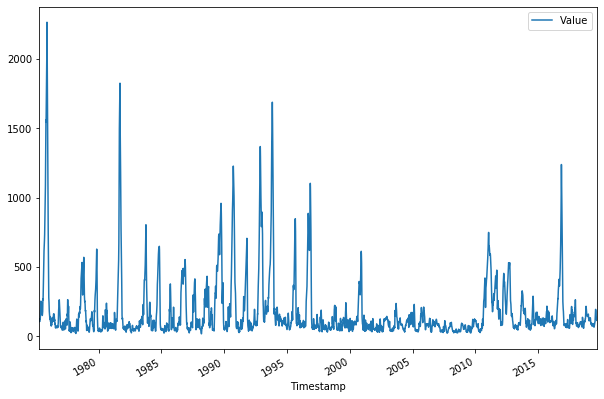

In [4]:
#What are the latitudes and longtitudes of the area you want to make a picture of?
lat = -34.71966901
lon = 143.1698626
buffer = 7000
#Where abouts is your csv file located on your computer?
csv_file_location = '~/Boundary_Bend.csv'

#Loading and organising guage data
gauge_data = pd.read_csv(csv_file_location,
                error_bad_lines = False, skiprows=9, escapechar='#', 
                         parse_dates=['Timestamp'], #Tells it this column is date format
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0]))
gauge_data = gauge_data.dropna()

gauge_data = gauge_data.drop(columns='Interpolation Type')
gauge_data = gauge_data.drop(columns='Quality Code')
gauge_data.plot(y='Value', figsize=(10,7))

In [5]:
#What discharge level range do you want to look at?
yaxis_lower_parameter = 300
yaxis_higher_parameter = 2500

#Dask loading wofs_albers data
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1988-01-01', '2019-08-22'), 
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)

#convert Pandas dataframe to xArray for merging with WOfS
gauge_data_xr = gauge_data.to_xarray() 

#this is the xArray merge function
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time) 

#Now define the passes to load based on user input
specified_satellite_passes = merged_data.where((merged_data.Value > yaxis_lower_parameter) & 
                                    (merged_data.Value < yaxis_higher_parameter), drop=True)
specified_satellite_passes = specified_satellite_passes.drop('Timestamp')

#Check how many passes you are about to load. I recommend loading 100 to 400 passes.
specified_satellite_passes  

<xarray.Dataset>
Dimensions:  (time: 177)
Coordinates:
  * time     (time) datetime64[ns] 1988-07-30T23:45:44.500000 ... 2016-12-11T00:17:28.500000
Data variables:
    Value    (time) float64 348.6 388.6 419.4 431.1 ... 560.8 532.3 360.6 343.2

# Load satellite data so you can cloud mask it

In [6]:
#make a list of dates for the for-loop to load
date_list = specified_satellite_passes.time.values

# load the passes that happened during the specified flow parameters
specified_passes = wofs_albers.sel(time=date_list).compute()

# Cloud mask
cc = masking.make_mask(specified_passes.water, cloud=True)
npixels_per_slice = specified_passes.water.shape[1]*specified_passes.water.shape[2]
npixels_per_slice
ncloud_pixels = cc.sum(dim='x').sum(dim='y')
cloud_pixels_fraction = (ncloud_pixels/npixels_per_slice)
clear_specified_passes = specified_passes.water.isel(time=cloud_pixels_fraction<0.3)

# Use pandas to merge the clear satellite data with the gauge data and plot. 

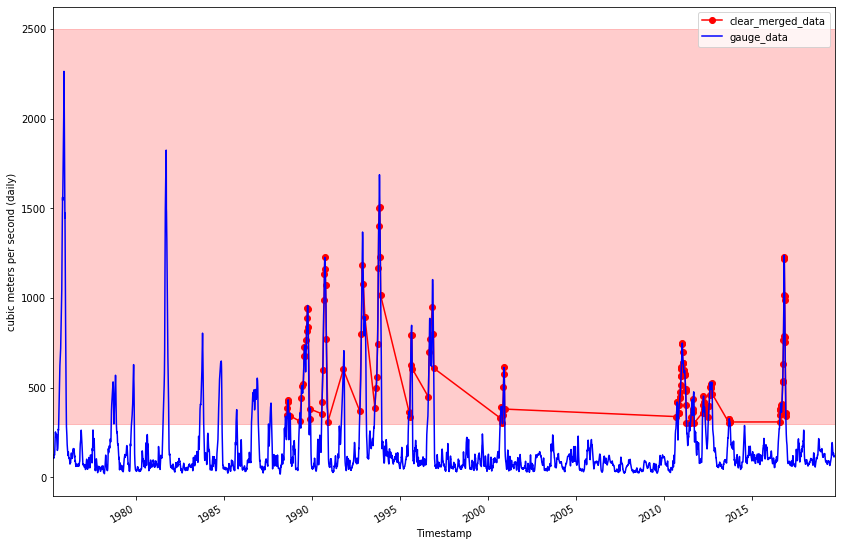

In [7]:
#Now take the clear passes and make it into a pandas dataframe that lists time of clear passes and corresponding gauge value
clear_specified_passes_pd = clear_specified_passes.time.to_dataframe()
clear_specified_passes_pd = clear_specified_passes_pd.rename(columns = {'time': 'date'})#can't have 2 columns called 'time' for the merge
merged_data_pd = merged_data.to_dataframe()

#Merge clear satellite passes with gauge data by the time dimension
clear_merged_data = pd.merge(clear_specified_passes_pd, merged_data_pd, left_on= 'time', 
                            right_index=True, how='inner')
clear_merged_data = clear_merged_data.drop(columns='date')
clear_merged_data = clear_merged_data.drop(columns='Timestamp')

#Plot the clear satellite passes over the hydrograph
ax = clear_merged_data.plot(marker = 'o', color='red', figsize=(14,10))
plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)
plt.ylabel('cubic meters per second (daily)')
gauge_data.plot(ax=ax, color='blue')
ax.legend(["clear_merged_data", "gauge_data"]);

In [11]:
scipy.signal.find_peaks(clear_merged_data, height=None, threshold=None, distance=None, 
                        prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)

AttributeError: module 'scipy' has no attribute 'signal'

In [ ]:
vv = clear_merged_data.values.ravel()
plt.plot(np.diff(vv)>1, '.')

In [ ]:
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global time_int, discharge_int, devent
    devent = event
    time_int = event.xdata
    discharge_int= event.ydata
    time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

In [ ]:
#Set up plot
fig = plt.figure(figsize=(11.69,8.27)) #Edit size of plot ##User should format as required

In [ ]:
fig.canvas.mpl_connect('button_press_event', callback) #Plot setup

In [ ]:
plt.title('Interactive Hydrograph')
plt.show() #Plot setup

In [ ]:
display(w)

In [ ]:
merged_data_array = merged_data.to_array()

In [ ]:
#Plot flow values
matplotlib.pyplot.plot_date(gauge_data, merged_data_array, ['Value'], 
                            label= 'Discharge') #plot all discharge values
matplotlib.pyplot.plot_date(subset_dates, subset_data['flow'], 'ro', #plot matched discharge values 
                            label='Discharge values with suitable satellite imagery') 

In [ ]:
#Axis details
firstyear =  min_date ###User modification: set period of interest use "min_date" variable for automatic scaling
lastyear = max_date ###User modification: set period of interest use "max_date" variable for automatic scaling
plt.axis([firstyear , lastyear ,min_flow, max_flow], 'tight') #Set axis
plt.yticks(size=12) #format size of date labels ##User should format if required
plt.xticks(rotation=45,size=12) #Rotate and format size of date labels ##User should format if required
plt.ylabel('Discharge (m$^3$ day$^{-1}$)', size=14) #Set Y label
plt.xlabel('Date', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=2, loc=9, fontsize=14) #Set legend location on plot ##User should format if required

In [ ]:
#Take into account user input for hydrograph
specified_level = merged_data.where((merged_data.Value > yaxis_lower_parameter) & 
                                    (merged_data.Value < yaxis_higher_parameter), drop=True)

#Make a list of dates to load based on user input
date_list = specified_level.time.values

In [ ]:
#Generate image
wet = (clear_specified_passes == 128).sum(dim='time')
dry = (clear_specified_passes == 0).sum(dim='time')
clear = wet + dry
frequency = wet / clear
frequency= frequency.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows

In [ ]:
frequency1 = frequency.where(frequency!=0)

#image generation
image = frequency1.plot(size=8)
image

In [ ]:
clear_specified_passes.time